In [1]:
import openfermion as op
import numpy as np
from openfermion.transforms import normal_ordered
from openfermion.transforms import jordan_wigner, bravyi_kitaev,reverse_jordan_wigner
from openfermion.ops import QubitOperator,FermionOperator
from openfermion.utils import hermitian_conjugated
from time import time
import cvxpy as cp

import spinSDP as sp
from tqdm.auto import tqdm

from openfermion.linalg import get_sparse_operator
from openfermion.linalg import get_ground_state

import matplotlib.pyplot as plt
import json

(CVXPY) May 20 03:25:38 PM: Encountered unexpected exception importing solver OSQP:
ImportError('dlopen(/Applications/miniconda3/envs/spins/lib/python3.12/site-packages/osqp/_osqp.cpython-312-darwin.so, 0x0002): symbol not found in flat namespace (_csc_matrix)')


In [2]:
def pauli_ANNNI_Ham(N,g= 0):
    res = 0
    for i in range(N):
        ip1 = (i+1)%N
        ip2 = (i+2)%N
        res += QubitOperator(f'X{i} X{ip1}') - QubitOperator(f'Z{i}') + g*QubitOperator(f'X{i} X{ip2}') + g*QubitOperator(f'Z{i} Z{ip1}')
    return -1*res

def get_gs(op):
    sparse = get_sparse_operator(op)
    return get_ground_state(sparse)

In [3]:
def c(i):
    return FermionOperator(f'{i}')
def cdag(i):
    return FermionOperator(f'{i}^')
def p(i):
    return 2*cdag(i)*c(i)-1

def fermi_ANNNI_Ham(N,g=0): # implement AP BCs for fermions by hand in here
    res = 0
    for j in range(N):
        jp1 = (j+1)%N
        jp2 = (j+2)%N
        if j < N - 2:
            first_term = p(j) - (cdag(j) - c(j))*(cdag(jp1) + c(jp1))
            g_term = -p(j)*p(jp1) + (cdag(j) - c(j))*p(jp1)*(cdag(jp2) + c(jp2))
        elif j == N-2:
            first_term = p(j) - (cdag(j) - c(j))*(cdag(jp1) + c(jp1))
            g_term = -p(j)*p(jp1) - (cdag(j) - c(j))*p(jp1)*(cdag(jp2) + c(jp2))
        elif j == N-1:
            first_term = p(j) + (cdag(j) - c(j))*(cdag(jp1) + c(jp1))
            g_term = -p(j)*p(jp1) - (cdag(j) - c(j))*p(jp1)*(cdag(jp2) + c(jp2))
        res += first_term +g*g_term
    return normal_ordered(res)

In [4]:
N = 12
energies = []
exact_gstates = []
# f_energies = []
gamrange = np.linspace(-2,2,41)
for gamma in tqdm(gamrange):
    Ha = pauli_ANNNI_Ham(N,g=gamma)
    energy,state = get_gs(Ha)
    energies.append(energy/N)
    exact_gstates.append(state)

  0%|          | 0/41 [00:00<?, ?it/s]

In [251]:
annni_exacts = {'g':list(gamrange),'e':energies,'s':[]}
for state in exact_gstates:
    state = list([(x.real,x.imag) for x in state])
    annni_exacts['s'].append(state)

with open('annni_results/exacts.json','w') as json_file:
    json.dump(annni_exacts,json_file)

## pauli sdp

In [287]:
B2(4)

[1.0 [X0],
 1.0 [Y0],
 1.0 [Z0],
 1.0 [X1],
 1.0 [Y1],
 1.0 [Z1],
 1.0 [X2],
 1.0 [Y2],
 1.0 [Z2],
 1.0 [X3],
 1.0 [Y3],
 1.0 [Z3],
 1.0 [X0 X1],
 1.0 [X1 X2],
 1.0 [X2 X3],
 1.0 [X0 X3],
 1.0 [Y0 Y1],
 1.0 [Y1 Y2],
 1.0 [Y2 Y3],
 1.0 [Y0 Y3],
 1.0 [Z0 Z1],
 1.0 [Z1 Z2],
 1.0 [Z2 Z3],
 1.0 [Z0 Z3],
 1.0 [X0 Y1],
 1.0 [X1 Y2],
 1.0 [X2 Y3],
 1.0 [Y0 X3],
 1.0 [Y0 Z1],
 1.0 [Y1 Z2],
 1.0 [Y2 Z3],
 1.0 [Z0 Y3],
 1.0 [X0 Z1],
 1.0 [X1 Z2],
 1.0 [X2 Z3],
 1.0 [Z0 X3],
 1.0 [Z0 X1],
 1.0 [Z1 X2],
 1.0 [Z2 X3],
 1.0 [X0 Z3],
 1.0 [Z0 Y1],
 1.0 [Z1 Y2],
 1.0 [Z2 Y3],
 1.0 [Y0 Z3],
 1.0 [Y0 X1],
 1.0 [Y1 X2],
 1.0 [Y2 X3],
 1.0 [X0 Y3]]

In [4]:
def B0(N):
    return sp.pauli_onept_basis(N)
def B1(N):
    return sp.pauli_twopt_basis(N,anchored = True)
def B2(N):
    return sp.pauli_twopt_basis(N,anchored = False)
def BF0(N):
    basis = B0(N)
    for i in range(N):
        basis.append(jordan_wigner(c(i)))
        basis.append(jordan_wigner(cdag(i)))
    return basis

def BF1(N):
    basis = B1(N)
    for i in range(N):
        basis.append(jordan_wigner(c(i)))
        basis.append(jordan_wigner(cdag(i)))
    return basis

def BF2(N):
    basis = B2(N)
    for i in range(N):
        basis.append(jordan_wigner(c(i)))
        basis.append(jordan_wigner(cdag(i)))
    return basis





def com(a,b):
    return a*b - b*a

In [253]:
bases = [BF2(N),BFF2(N)]#[B2(N),BF0(N),BF1(N),BF2(N),BFF2(N)]
basis_names = ['Bf2','bff2']# [r'$\mathcal{B}_2$',r'$\mathcal{B}^{(0)}_F$',r'$\mathcal{B}^{(1)}_F$',r'$\mathcal{B}^{(2)}_F$',r'$\tilde{B}_F$']
basis_keys = ['bf2','bff2']#['B2','BF0','BF1','BF2','BFF2']
basis_estimates = {}
basis_xxv = {}
for k,basis in enumerate(bases):
    print("doing basis",basis_names[k])
    sdp = sp.pauliSDP(basis,N = N,timed = False)
    print("number of vars",sdp.n_duals)
    print("Mshape",sdp.Mshape)
    estimates = []
    xx_ests = []
    for g in tqdm(gamrange):
        hh = pauli_ANNNI_Ham(N,g=g)
        sdp.objective(hh)
        res,opt = sdp.solve()
        corrs = sdp.get_corrs()
        sites,xxv = corrs['XX']
        xx_ests.append(xxv)
        estimates.append(res)
    basis_estimates[basis_keys[k]] = estimates
    basis_xxv[basis_keys[k]] = xx_ests


doing basis Bf2
number of vars 2277
Mshape (169, 169)


  0%|          | 0/41 [00:00<?, ?it/s]

KeyboardInterrupt: 

KeyError: 'bf2'

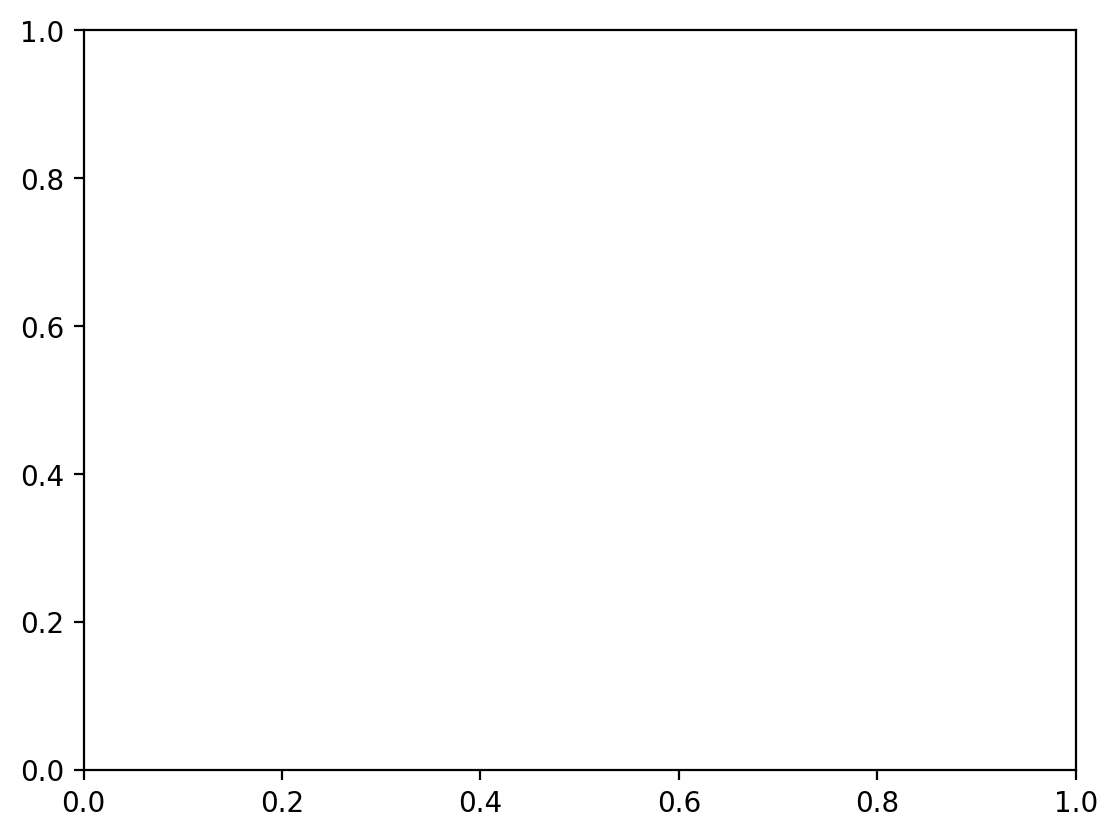

In [267]:
fig,ax = plt.subplots(dpi = 200)
energies = np.array(energies)
for k,key in enumerate(basis_keys):
    estimates = np.array(basis_estimates[key])
    perr = np.abs(estimates - energies)/np.abs(energies)*100
    plt.plot(gamrange,perr,label = basis_names[k])
# plt.plot(gamrange,energies,'k--',label = 'exact diag')
# plt.plot(gamrange,estimates,label = 'sdp')
plt.xlabel("gamma")
plt.ylabel('energy percent error')
plt.yscale('log')
plt.vlines([0],1e-5,1e2,linestyle = 'dashed',color = 'black',label = "Ising point")
plt.vlines([-0.286],1e-5,1e2,linestyle = 'dotted',color = 'black',label = "Ising CFT limit")
plt.ylim(1e-5,1e2)
plt.xlim(min(gamrange),max(gamrange))
plt.legend()
plt.title("Energy error in the ANNNI SDP")
# plt.savefig('annni_results/energy_error.pdf',bbox_inches = 'tight')
plt.show()

## ANNNI XX correlator

In [356]:
N = 10
gam_values = [-1,-0.1,2]
states = []
for gamma in tqdm(gam_values):
    Ha = pauli_ANNNI_Ham(N,g=gamma)
    energy,state = get_gs(Ha)
    states.append(state)

  0%|          | 0/3 [00:00<?, ?it/s]

In [359]:
bases = [B2(N),BF0(N),BF1(N),BF2(N),BFF2(N)]
basis_names = [r'$\mathcal{B}_2$',r'$\mathcal{B}^{(0)}_F$',r'$\mathcal{B}^{(1)}_F$',r'$\mathcal{B}^{(2)}_F$','new']
basis_keys = ['B2','BF0','BF1','BF2','BFF2']
basis_xxcorrs = {}
# basis_threepts = {}
# threept_ops = [4*QubitOperator(f'X0 X{n}') - 4*QubitOperator(f'Z0 X1 X{n}') - 4*QubitOperator(f'Z0 X{N-1} X{n}') for n in range(1,N-1)]
for k,basis in enumerate(bases):
    print("doing basis",basis_names[k])
    sdp = sp.pauliSDP(basis,N = N,timed = False)
    print("number of vars",sdp.n_duals)
    print("Mshape",sdp.Mshape)
    estimates = []
    threepts = []
    for g in tqdm(gam_values):
        hh = pauli_ANNNI_Ham(N,g=g)
        sdp.objective(hh)
        res,opt = sdp.solve()
        corrs = sdp.get_corrs()
        sites,xxv = corrs['XX']
        estimates.append(xxv)
            
    basis_xxcorrs[basis_names[k]] = estimates

doing basis $\mathcal{B}_2$
number of vars 522
Mshape (121, 121)


  0%|          | 0/3 [00:00<?, ?it/s]

doing basis $\mathcal{B}^{(0)}_F$
number of vars 424
Mshape (51, 51)


  0%|          | 0/3 [00:00<?, ?it/s]

doing basis $\mathcal{B}^{(1)}_F$
number of vars 618
Mshape (60, 60)


  0%|          | 0/3 [00:00<?, ?it/s]

doing basis $\mathcal{B}^{(2)}_F$
number of vars 1445
Mshape (141, 141)


  0%|          | 0/3 [00:00<?, ?it/s]

doing basis new
number of vars 4773
Mshape (456, 456)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

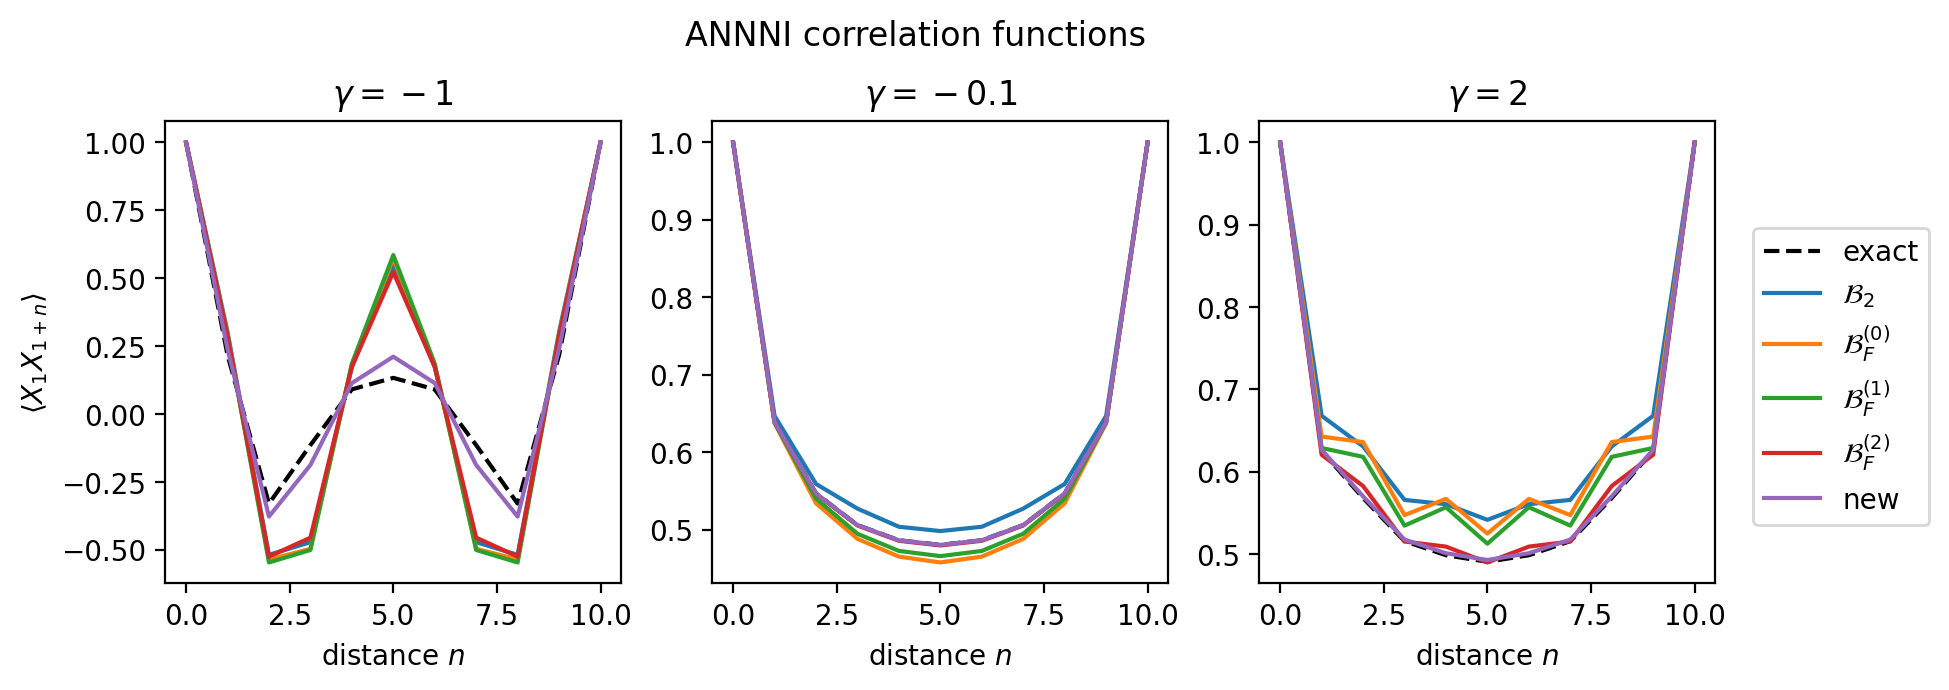

In [364]:
fig,ax = plt.subplots(1,3,figsize = (10,3),dpi = 200)
basis_names = [r'$\mathcal{B}_2$',r'$\mathcal{B}^{(0)}_F$',r'$\mathcal{B}^{(1)}_F$',r'$\mathcal{B}^{(2)}_F$','new']
basis_keys = ['B2','BF0','BF1','BF2','BFF2']
fig.suptitle("ANNNI correlation functions",y =1.05)
for i,g in enumerate(gam_values):
    XXops = [get_sparse_operator(QubitOperator(f'X0 X{i}'),n_qubits = N) for i in range(N)]
    xx_exact = []
    state = states[i]
    for op in tqdm(XXops):
        state_dag = state.conj().T
        Mv = op.dot(state)
        xx_exact.append(np.real(state_dag.dot(Mv)))
    xx_exact += [1]
    # sites = np.arange(1,N+1)
    basis_results = {}
    for name in basis_names:
        basis_results[name] = basis_xxcorrs[name][i]
    
    if i == 0:
        ax[i].plot(xx_exact,'k--',label = 'exact')
        ax[i].set_xlabel(r"distance $n$")
        ax[i].set_ylabel(r"$\langle X_1X_{1+n}\rangle$")
        ax[i].set_title(r"$\gamma ={}$".format(g))

        for name in basis_names:
            ax[i].plot(basis_results[name],label = name)

        ax[i].legend(bbox_to_anchor = (3.9,0.8))
    else:
        ax[i].plot(xx_exact,'k--',label = 'exact')
        ax[i].set_xlabel(r"distance $n$")
        ax[i].set_title(r"$\gamma ={}$".format(g))
        for name in basis_names:
            ax[i].plot(basis_results[name],label = name)

# plt.savefig('annni_results/annni_corrcompare.pdf',bbox_inches = 'tight')

In [370]:
basis_names = [r'$\mathcal{B}_2$',r'$\mathcal{B}^{(0)}_F$',r'$\mathcal{B}^{(1)}_F$',r'$\mathcal{B}^{(2)}_F$','new']

In [384]:
xx = np.arange(N+1)
name = basis_names[-2]
yy = basis_xxcorrs[name][2]
name

'$\\mathcal{B}^{(2)}_F$'

In [387]:
sp.getCritExp(xx,yy,N = N,cutoff = 4)

0.38371638955791515

In [386]:
(0.125-0.114)/0.125*100

8.799999999999997

### estimate lattice speed of light

In [47]:
def full_twopt_basis(N):
    basis = sp.pauli_onept_basis(N)
    newops = ['XX','YY','ZZ','XY','XZ']#,'ZX','ZY','YX']
    for corr in newops:
        for i in range(N):
            for j in range(i+1,N+i):
                newop = QubitOperator(f'{corr[0]}{i} {corr[1]}{j%N}')
                if newop not in basis:
                    basis.append(newop)
    return basis

def BFF2(N):
    basis = full_twopt_basis(N)
    for i in range(N):
        basis.append(jordan_wigner(c(i)))
        basis.append(jordan_wigner(cdag(i)))
    return basis

In [57]:
# setup basic parameters
N = 12
basis = BFF2(N)
print(len(basis))
gamma = 2
hamiltonian = pauli_ANNNI_Ham(N,g = gamma)

# compute operator to use for speed of light
X = QubitOperator('X0')
xdd = -1*com(hamiltonian,com(hamiltonian,X))

# determine and make minimal basis additions to get the operator correctly 
for op in xdd:
    op = op/op.op_coeff()
    if op not in basis:
        basis.append(op)

522


In [58]:
# solve initial SDP (for crit exp)
sdp = sp.pauliSDP(basis,bcs = (N,'cyclic'),v =True,timed = True)
sdp.objective(hamiltonian)
# for op in sp.pauli_onept_basis(N):
#     sdp.add_constraint(com(hamiltonian,op))
res,opt = sdp.solve(solver = cp.MOSEK,verbose = True)
corrs = sdp.get_corrs()

Matrix size: (536, 536)
find M, Fmats time = 6.776656150817871
Number of dual variables: 10503
Solving SDP....
                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) May 20 03:56:25 PM: Your problem has 10503 variables, 1 constraints, and 10503 parameters.
(CVXPY) May 20 03:56:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 03:56:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 20 03:56:25 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 20 03:56:26 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 20 03

In [64]:
len(sdp.basis)

536

In [65]:
exact = get_gs(hamiltonian)[0]/N
est = res/N
print("exact:",exact)
print('est:',est)
print('perr:',abs((exact-est)/exact)*100)

exact: -3.511163821106914
est: -3.514077429367864
perr: 0.08298126801817708


Estimated X scaling dimension: 0.12575163877008633


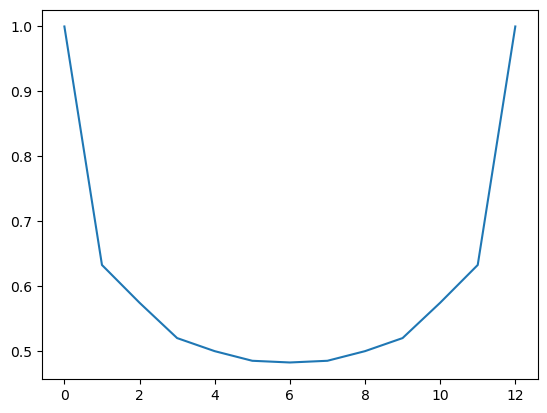

In [66]:
# compute critical exponent
xx,yy = corrs['XX']
plt.plot(xx,yy)
crit_exp = sp.getCritExp(xx,yy,N = N,cutoff = 2)
print('Estimated X scaling dimension:',crit_exp)

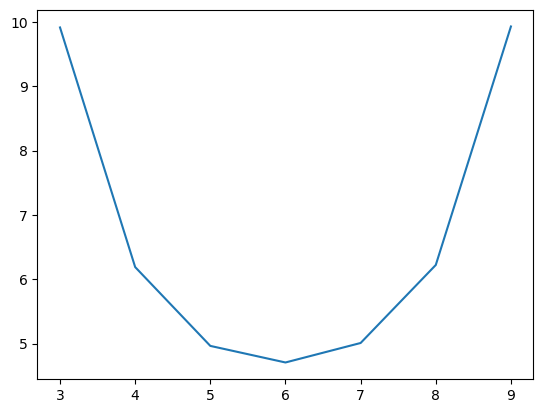

In [67]:
cut = 3
sites = np.arange(cut,N+1-cut)
xdd_xn = np.array([sdp.get_opt_val(xdd*QubitOperator(f'X{i}')) for i in sites])
normal_xn = np.array([sdp.get_opt_val(QubitOperator(f'X0 X{i}')) for i in sites])
plt.plot(sites,xdd_xn/normal_xn)

In [68]:
from scipy.optimize import curve_fit

def curve(n,v):
    return 2*np.pi**2*(v)**2*crit_exp/(N**2)*1/np.sin(sites*np.pi/N)**2

popt, pcov = curve_fit(curve, sites, xdd_xn/normal_xn)
v_eff = popt[0]
print("effective speed of light:",v_eff)

effective speed of light: 16.725671047420867


In [69]:
from tqdm.auto import tqdm
Nrange = range(6,13)
results = []
for N in tqdm(Nrange):
    operator_basis = BFF2(N)#+ [QubitOperator('Z0 X1'),QubitOperator(f'Z0 X{N-1}')]
    sdp = sp.pauliSDP(operator_basis,bcs = (N,'cyclic'),timed = True,v = True)
    gamma = 2
    hamiltonian = pauli_ANNNI_Ham(N,g = gamma)
    sdp.objective(hamiltonian)
    
    res,opt = sdp.solve()
    results.append(res/N)

  0%|          | 0/7 [00:00<?, ?it/s]

Matrix size: (136, 136)
find M, Fmats time = 0.1971421241760254
Number of dual variables: 461
Solving SDP....
Result: -21.59683234112883
solve time 3.590785026550293
Matrix size: (183, 183)
find M, Fmats time = 0.3003251552581787
Number of dual variables: 941
Solving SDP....
Result: -24.962669889857764
solve time 6.413053274154663
Matrix size: (237, 237)
find M, Fmats time = 0.8489477634429932
Number of dual variables: 1724
Solving SDP....
Result: -28.37703874688761
solve time 13.788938045501709
Matrix size: (298, 298)
find M, Fmats time = 1.5737097263336182
Number of dual variables: 2827
Solving SDP....
Result: -31.806461447766864
solve time 37.773191928863525
Matrix size: (366, 366)
find M, Fmats time = 2.3585381507873535
Number of dual variables: 4348
Solving SDP....
Result: -35.2518717275303
solve time 81.56001591682434
Matrix size: (441, 441)
find M, Fmats time = 3.6222341060638428
Number of dual variables: 6308
Solving SDP....
Result: -38.706714204695714
solve time 133.7291162014

In [70]:
# fit finite-size scaling
def fss(N,e0,c):
    return e0 - np.pi*c*v_eff/(6*N**2)
popt, pcov = curve_fit(fss, np.array(Nrange),results)

In [71]:
popt

array([-3.48448945,  0.4657262 ])

## fermi sdp

In [46]:
def F0(N):
    basis = sp.fermi_onept_basis(N)
    for i in range(N):
        ip1 = (i+1)%N
        basis.append(c(i)*c(ip1))
        basis.append(c(i)*cdag(ip1))
        basis.append(cdag(i)*c(ip1))
        basis.append(cdag(i)*cdag(ip1))
    return basis

def F1(N):
    basis = F0(N)
    for i in range(N):
        ip2 = (i+2)%N
        basis.append(c(i)*c(ip2))
        basis.append(c(i)*cdag(ip2))
        basis.append(cdag(i)*c(ip2))
        basis.append(cdag(i)*cdag(ip2))
    return basis

def com(a,b):
    return a*b - b*a

In [56]:
sdp.obj_offset

164.00000000000003

In [57]:
bases = [F0(N)]
basis_names = ['F0']
basis_estimates = {}
for k,basis in enumerate(bases):
    print("doing basis",basis_names[k])
    sdp = sp.fermiSDP(basis,N = N,timed = False)
    print("number of vars",sdp.n_duals)
    print("Mshape",sdp.Mshape)
    estimates = []
    for g in tqdm(gamrange):
        hh = fermi_ANNNI_Ham(N,g=g)
        sdp.objective(hh)
        # ops_to_com = [c(i) for i in range(N)] + [cdag(i) for i in range(N)]
        for op in sdp.duals:
            sdp.add_constraint(com(hh,op))
        res,opt = sdp.solve()
        estimates.append(res)
    basis_estimates[basis_names[k]] = estimates

doing basis F0
number of vars 848
Mshape (49, 49)


  0%|          | 0/41 [00:00<?, ?it/s]


Operator -10.0 [2^ 0^ 1 0] wasn't found in basis.

Operator -10.0 [2^ 1^ 0^ 0] wasn't found in basis.

Operator 10.0 [2^ 0^ 1 0] wasn't found in basis.

Operator -10.0 [2^ 1^ 0^ 0] wasn't found in basis.

Operator -10.0 [2^ 0^ 2 1] wasn't found in basis.

Operator 10.0 [2^ 0^ 2 1] wasn't found in basis.

Operator -20.0 [1^ 0^ 2 0] wasn't found in basis.

Operator 20.0 [2^ 1^ 0^ 0] wasn't found in basis.

Operator -10.0 [3^ 1^ 3 2] wasn't found in basis.

Operator 10.0 [3^ 1^ 3 2] wasn't found in basis.

Operator -20.0 [2^ 1^ 3 1] wasn't found in basis.

Operator 20.0 [3^ 2^ 1^ 1] wasn't found in basis.

Operator -10.0 [4^ 2^ 4 3] wasn't found in basis.

Operator 10.0 [4^ 2^ 4 3] wasn't found in basis.

Operator -20.0 [3^ 2^ 4 2] wasn't found in basis.

Operator 20.0 [4^ 3^ 2^ 2] wasn't found in basis.

Operator -10.0 [5^ 3^ 5 4] wasn't found in basis.

Operator 10.0 [5^ 3^ 5 4] wasn't found in basis.

Operator -20.0 [4^ 3^ 5 3] wasn't found in basis.

Operator 20.0 [5^ 4^ 3^ 3] wasn't

In [62]:
(np.array(basis_estimates['F0'])-2*sdp.obj_offset)/N

array([-50.54538856, -46.21465562, -42.05906217, -38.07857199,
       -34.27319822, -30.64295596, -27.18786276, -23.90793932,
       -20.80321014, -17.87370443, -15.1194573 , -12.54051124,
       -10.13691812,  -7.9087419 ,  -5.85606227,  -3.97897964,
        -2.27762225,  -0.75215613,   0.59720639,   1.77019101,
         2.76641115,   3.5853041 ,   4.22599616,   4.68738747,
         4.96775711,   5.06122598,   4.91917073,   4.452789  ,
         3.63434469,   2.47280831,   1.11819243,  -0.41761907,
        -2.13490265,  -4.03238353,  -6.10887498,  -8.36327426,
       -10.79459348, -13.40246044, -16.18667153, -19.14710402,
       -22.28372663])

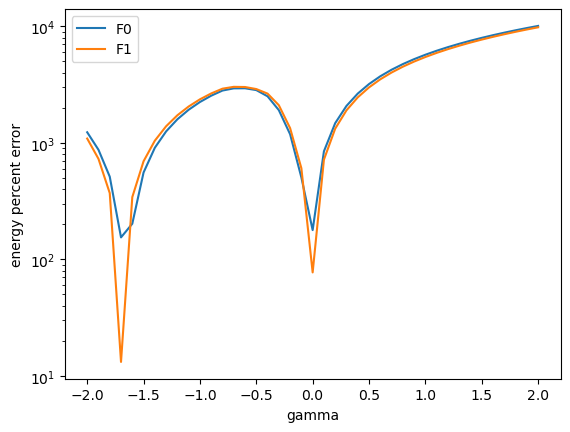

In [24]:
energies = np.array(energies)
for basis in basis_names:
    estimates = np.array(basis_estimates[basis])
    perr = np.abs(estimates - energies)/np.abs(energies)*100
    plt.plot(gamrange,perr,label = basis)
# plt.plot(gamrange,energies,'k--',label = 'exact diag')
# plt.plot(gamrange,estimates,label = 'sdp')
plt.xlabel("gamma")
plt.ylabel('energy percent error')
plt.yscale('log')
plt.legend()

In [9]:
basis = F0(N)
sdp = sp.fermiSDP(basis,N=N,v = True,timed = True)
sdp.objective(Ha)
commed = [com(Ha,op) for op in sdp.duals]
sdp.add_constraint(commed)
    
res,opt = sdp.solve(verbose = False,ignore_dpp = True)
print(res/N)

find M, Fmats time = 0.1237032413482666
Number of dual variables: 848
20704 constraints not representable.
Solving SDP....


/Applications/miniconda3/envs/spins/lib/python3.12/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


Result: -26.057314883385178
solve time 1.5939381122589111
-3.2571643604231473


In [94]:
N = 8
energies = []
gamrange = [1]
for gamma in tqdm(gamrange):
    Ha = fermi_ANNNI_Ham(N,g=gamma)
    energy,_ = get_gs(Ha)
    energies.append(energy/N)

  0%|          | 0/41 [00:00<?, ?it/s]